# Taking Over the Stock Market: Adversarial Perturbations Against Algorithmic Traders


---

This notebook presents the main contributions of our work submitted to ECML-PKDD 2021. 

We provided the implementation of our work to help researchers understand better the existence of adversarial examples in the trading domain and to help researchers to easily extend our work.

The main parts are:
- Read and preprocess the data
- Build and train the alpha models
- Generate a Targeted Universal Perturbation
- Evaluate and visualize the results
- Build and evaluate mitigation solutions


Imports:

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM,Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Reshape
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from numpy.random import seed
from math import sqrt
import numpy as np # linear algebra
import pandas as pd # data processing
from datetime import datetime
import timeit

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


TensorFlow 1.x selected.


Using TensorFlow backend.


Mounted at /content/drive/


# preprocess





Load one symbol:

In [ ]:
# read the data and define the columns
def readSymbolData(Symbol):
    # Symbol must be the stock specific name as a string
    data = pd.read_csv('path_to_our_dir/splited_s&p500/'+Symbol+'.csv',parse_dates=['Unnamed: 0.1'])
    #fill nan with last val instance
    data = data.fillna(method='ffill')
    # for cases where the first raw is missing
    X = pd.DataFrame(removeEarly(data))
    X.columns = ['Date', 'Open','High','Low','Close','Volume']
    return X

# remove missing values
def removeEarly(data):
    for i in range(50):
    if not data.iloc[i,5] == 'close':
        return data.iloc[i:, 1:]
    
# parsing the hour and minute out from the time stamp
def parse_hour(time):
    time = datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    return time.hour - 9

def parse_minute(time):
    time = datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    return time.minute

# parsing and adding minute, hour to the data
def parseTime(X):
    # parsing time to hour and minute
    X['Minute'] = X['Date'].apply(parse_minute)
    X['Hour'] = X['Date'].apply(parse_hour)
    return X

# aggregating the data to extract avg,std,trend,time
def np_agg_perN(data, aggN):
    avg,std,trend,minute,hour,close = [],[],[],[],[],[]
    for i in range(int(len(data)/aggN)):
        start = i*aggN
        curData = np.array(data[start:start+aggN,4], dtype=np.float64)
        avg.insert(i, np.mean(curData, dtype=np.float64))
        std.insert(i, np.std(curData, dtype=np.float64))
        a1_param,_ = np.polyfit(range(aggN), curData, 1)
        trend.insert(i, a1_param)
        minute.append(data[start+aggN-1,6]) #minute
        hour.append(data[start+aggN-1,7]) #hour
        close.append(data[start+aggN-1,4]) # close
    return np.array(avg), np.array(std), np.array(trend), np.array(minute), np.array(hour), np.array(close)

# calculates the pseudo log return (difference between avg prices)
def np_pseudoLogReturn(data):
    PLogReturn = []
    for i in range(len(data)):
    if(i>0):
        PLogReturn.append(np.log(data[i]/data[i-1])) 
    return np.array(PLogReturn, dtype = np.float64)

# evaluation for classifier: mse, acc
def eval_clf_Model(prediction, y_test):
    mse = mean_squared_error(y_test, prediction)
    print('mse: ' + str(mse))
    acc = accuracy_score(y_test, prediction)
    print('Accuracy:'+str(acc))
    
    return mse, acc
  
#preper the time series data chanks
def np_processData(data,lookBack):
    X,Y = [],[]
    shapaes = []
    for i in range(len(data)-lookBack):        
        X.append(np.matrix(data[i:(i+lookBack),:]))
        Y.append(data[(i+lookBack),0])   #need to be careful with 
    return np.array(X),np.array(Y)
  
# Full preproccess for our classification task:
def np_clf_aggAndSliceData(X, aggParam=5, lookBack=5, disjoint = False):
    # Aggrigation of the data to get std and trend indicatiors
    avg, std, trend, minute, hour, close = np_agg_perN(X,aggParam)
    logAVG = np_pseudoLogReturn(avg)

    minute = minute.reshape(len(minute),1)
    hour = hour.reshape(len(hour),1)
    close = close.reshape(len(close),1)
    avg = avg.reshape(len(avg),1)
    X_time = np.concatenate([minute,hour,close,avg],axis=1)

    logAVG = logAVG.reshape(len(logAVG),1)
    std = std[1:]
    trend = trend[1:]
    std = std.reshape(len(std),1)
    trend = trend.reshape(len(trend),1)
    procData = np.concatenate([logAVG,std,trend],axis=1)

    #  create data & split by 70-30 rate  
    proc_x, proc_y = np_processData(procData,lookBack)
    X_train = np.reshape(proc_x, (proc_x.shape[0],proc_x.shape[1]*proc_x.shape[2]))
    X_time = X_time[lookBack:-1]
    merged = np.concatenate([X_train,X_time],axis=1)
    merged = np.array(merged,dtype=float)
    proc_y = proc_y>0
    proc_y = proc_y.astype(int)
    proc_y = keras.utils.to_categorical(proc_y)
    # shrink the data for disjoint samples if needed
    if disjoint == True:
        merged = np.array([merged[i*5] for i in range(int(np.floor(merged.shape[0]/5)))])
        proc_y = np.array([proc_y[i*5] for i in range(int(np.floor(proc_y.shape[0]/5)))])
    X_train,X_test = merged[:int(merged.shape[0]*0.7)],merged[int(merged.shape[0]*0.7):]
    y_train,y_test = proc_y[:int(proc_y.shape[0]*0.7)],proc_y[int(proc_y.shape[0]*0.7):]
    return X_train, X_test, y_train, y_test

def get_train_data(rawData, aggParam, lookBack):
    X_train1, X_test1, y_train1, y_test1 = np_clf_aggAndSliceData(X, aggParam, lookBack)
    X_train2, X_test2, y_train2, y_test2 = np_clf_aggAndSliceData(X[1:], aggParam, lookBack)
    X_train3, X_test3, y_train3, y_test3 = np_clf_aggAndSliceData(X[2:], aggParam, lookBack)
    X_train4, X_test4, y_train4, y_test4 = np_clf_aggAndSliceData(X[3:], aggParam, lookBack)
    X_train5, X_test5, y_train5, y_test5 = np_clf_aggAndSliceData(X[4:], aggParam, lookBack)
    X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4, X_train5), axis=0)
    y_train = np.concatenate((y_train1,y_train2,y_train3,y_train4,y_train5), axis=0)
    return X_train, y_train


# model

In [ ]:
# locking the RNG seed for better evaluation
def lockSeed():
    seed(1)
    tf.random.set_random_seed(2)

# create DNN model
def create_DNN_clf(X_train, y_train, nFeatures, nEpochs):
    model = Sequential()

    model.add(Dense(nFeatures, activation='tanh', input_shape=(nFeatures,)))
    model.add(Dense(int(np.floor(4*nFeatures/5)), activation='tanh'))
    model.add(Dense(int(np.floor(3*nFeatures/5)), activation='tanh'))
    model.add(Dense(int(np.floor(2*nFeatures/5)), activation='tanh'))
    model.add(Dense(int(np.floor(nFeatures/5)), activation='tanh'))

    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train[:,:nFeatures],y_train,validation_split = 0.2,epochs=nEpochs,shuffle=True,verbose=0)
    return model, history

#create 1d CNN model
def create_1dCNN_clf(X_train, y_train, nFeatures, nEpochs):
    model = Sequential()
    model.add(Reshape((5, 3), input_shape=(15,)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(5,3)))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit(X_train[:,:nFeatures-2], y_train,validation_split = 0.2,epochs=nEpochs, batch_size=32,shuffle=True, verbose=0)
    return model, history

#create RNN model
def create_RNN_clf(X_train, y_train, nFeatures, nEpochs):
    model = Sequential()
    model.add(Reshape((5, 3), input_shape=(15,)))
    model.add(LSTM(50,input_shape=(5,3),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50,return_sequences=False))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train[:,:nFeatures-2], y_train,validation_split = 0.2,epochs=nEpochs, batch_size=32,shuffle=True, verbose=0)
    return model, history


# TUAP


In [ ]:
# preprocces for one sample at a time
def np_clf_preprocces_one_sample(X, aggParam=5, lookBack=5):
    # Aggrigation of the data to get std and trend indicatiors
    avg, std, trend, minute, hour, close = np_agg_perN(X,aggParam)
    logAVG = np_pseudoLogReturn(avg)

    minute = minute.reshape(len(minute),1)
    hour = hour.reshape(len(hour),1)
    close = close.reshape(len(close),1)
    avg = avg.reshape(len(avg),1)
    X_time = np.concatenate([minute,hour,close,avg],axis=1)

    logAVG = logAVG.reshape(len(logAVG),1)
    std = std[1:]
    trend = trend[1:]
    std = std.reshape(len(std),1)
    trend = trend.reshape(len(trend),1)
    procData = np.concatenate([logAVG,std,trend],axis=1)

    #  create data & split by 80-20 rate  
    proc_x, proc_y = np_processData(procData,lookBack)
    X_train = np.reshape(proc_x, (proc_x.shape[0],proc_x.shape[1]*proc_x.shape[2]))
    X_time = X_time[lookBack:-1]
    merged = np.concatenate([X_train,X_time],axis=1)
    merged = np.array(merged,dtype=float)
    proc_y = proc_y>0
    proc_y = proc_y.astype(int)
    proc_y = keras.utils.to_categorical(proc_y, num_classes=2)

    return merged, proc_y

# fitting the uap and creating the adversarial input data
def prep(data, UAP, aggParam=5, lookBack=5):
    arr_x, arr_y = [], []
    for x in data:
        if type(UAP) == type(0):
            _x, _y = np_clf_preprocces_one_sample(x, aggParam, lookBack)
        else:
            zeroPad = np.zeros(shape=x.shape, dtype=np.float32)
            zeroPad[:,1:] += np.array(x[:,1:], dtype=np.float32)+UAP
            _x, _y = np_clf_preprocces_one_sample(zeroPad, aggParam, lookBack)
        arr_x.append(_x[0])
        arr_y.append(_y[0])
    arr_x = np.array(arr_x)
    arr_y = np.array(arr_y)
    return arr_x, arr_y

# evaluation for untargeted attack
def eval_UAP(model, UAP, data, nFeatures):
    X_ben, y = prep(data, 0)
    X_adv, _ = prep(data, UAP)
    orig_preds = model.predict(X_ben[:,:nFeatures])
    orig_preds = np.argmax(orig_preds, axis=-1)
    orig_preds = keras.utils.to_categorical(orig_preds,2)
    adv_preds = model.predict(X_adv[:,:nFeatures])
    adv_preds = np.argmax(adv_preds, axis=-1)
    adv_preds = keras.utils.to_categorical(adv_preds,2)
    accFlips = 1 - accuracy_score(orig_preds, adv_preds)
    accTrue = accuracy_score(y, adv_preds)
    orig_accTrue = accuracy_score(y, orig_preds)
    return accFlips, accTrue, orig_accTrue

# evaluation for targeted uap
def eval_UAP_targeted(model, UAP, data, target,aggParam, lookBack, nFeatures):
    UAP = fitUAP(UAP, data[0])
    X_ben, y = prep(data, 0,aggParam, lookBack)
    X_adv, _ = prep(data, UAP,aggParam, lookBack)
    for i in range(y.shape[0]):
        y[i] = target
    orig_preds = model.predict(X_ben[:,:nFeatures])
    orig_preds = np.argmax(orig_preds, axis=-1)
    orig_preds = keras.utils.to_categorical(orig_preds,2)
    adv_preds = model.predict(X_adv[:,:nFeatures])
    adv_preds = np.argmax(adv_preds, axis=-1)
    adv_preds = keras.utils.to_categorical(adv_preds,2)
    accFlips = 1 - accuracy_score(orig_preds, adv_preds)
    acc_mal_Target = accuracy_score(y, adv_preds)
    acc_ben_Target = accuracy_score(y,orig_preds)
    return accFlips, acc_ben_Target,acc_mal_Target

# eval random perturbations
def eval_rand_noise(model,data,target,size,nFeatures):
    rand_perturbs = [getRandomUAP(size) for i in range(10)]
    flips, acc_rnd = [],[]
    for perturb in rand_perturbs:
        rndFlips, acc_ben_Target,acc_rnd_Target = eval_UAP_targeted(model,perturb,data,target,5,5,nFeatures)
        flips.append(rndFlips)
        acc_rnd.append(acc_rnd_Target)
    return np.mean(flips), np.mean(acc_rnd), acc_ben_Target


# add padding for different window sizes if needed
def fitUAP(UAP,x):
    pad = np.zeros((x.shape[0],UAP.shape[-1]))
    pad[x.shape[0]-UAP.shape[0]:,:] = UAP
    return pad


In [ ]:
# targeted universal perturbation algorithm 
def targeted_UAP(train_set, model,target_label ,isSeries = 0 ):
  aggN = 5
  input_shape = (35,7)
  num_classes = 2
  volume = np.median(np.array(train_set[:,1,4],dtype=np.float32))*0.002 #0.2% of the price
  step = volume/25 # arbitrary step  
  
  # define the perturbation surface 
  mask = np.zeros(input_shape,dtype=np.float32 )
  for i in range(25):
    mask[i+5,3] = 1.

  ######## Build the tensor graph including preprocces ###########

  # define Variables 
  data = tf.placeholder(tf.float32, shape=input_shape)
  target = tf.placeholder(tf.float32, (1,2))
  global_uap = tf.Variable(np.zeros(input_shape, dtype=np.float32))
  perturbation = tf.Variable(np.zeros(input_shape, dtype=np.float32))

  x_adv = (global_uap + perturbation)*mask + data

  ########### preprocess ########################
  cSlices = int(np.floor(35/aggN))
  slices = tf.stack([x_adv[i*aggN:i*aggN+aggN, 3] for i in range(cSlices)])
  avg = tf.reduce_mean(slices, axis=1)
  std = tf.keras.backend.std(slices, axis=1)

  #compute the trend indicator
  x = np.arange(1, aggN + 1, dtype = np.float32)
  b1 = aggN*tf.reduce_sum(x*slices, axis=1)-tf.reduce_sum(x)*tf.reduce_sum(slices, axis=1)
  trend = b1/(aggN*tf.reduce_sum(x**2) - tf.reduce_sum(x)**2)

  #fix time vars
  minute = tf.stack([x_adv[i*aggN+aggN-1, 5] for i in range(cSlices)])# minute
  hour = tf.stack([x_adv[i*aggN+aggN-1, 6] for i in range(cSlices)])# hour
  close = tf.stack([x_adv[i*aggN+aggN-1, 3] for i in range(cSlices)])# close

  #tf pseudoLogReturn
  avg_next = tf.concat([[0],tf.identity(avg)],axis=0)
  avg = tf.concat([avg,[0]],axis=0)
  logAVG = tf.log(avg/avg_next)[1:avg.shape[0]-1]
  avg = avg[:avg.shape[0]-1]

  #concat time vars
  minute = tf.reshape(minute,[minute.shape[0],1])
  hour = tf.reshape(hour, [hour.shape[0],1])
  close = tf.reshape(close, [close.shape[0],1])
  avg = tf.reshape(avg,[avg.shape[0],1])
  X_time = tf.concat([minute,hour,close,avg],axis=1)

  #concat procData
  logAVG = tf.reshape(logAVG,[logAVG.shape[0],1])
  std = std[1:]
  trend = trend[1:]
  std = tf.reshape(std, [std.shape[0],1])
  trend = tf.reshape(trend, [trend.shape[0],1])
  procData = tf.concat([logAVG,std,trend],axis=1)

  #create data 
  proc_x = tf.stack([procData[i:i+lookBack,:] for i in range(procData.shape[0]-lookBack)])
  proc_y = tf.stack([procData[i+lookBack,0] for i in range(procData.shape[0]-lookBack)])
  proc_y = tf.convert_to_tensor(proc_y)
  proc_y = tf.to_int32(tf.clip_by_value(tf.sign(proc_y), 0,1))
  proc_y = tf.one_hot(proc_y,2)


  X_lastN = tf.reshape(proc_x, [proc_x.shape[0],proc_x.shape[1]*proc_x.shape[2]])
  X_time = X_time[lookBack:-1,:]
  merged = tf.concat([X_lastN,X_time],axis=1)

  sample_x = merged
  sample_y = proc_y
  ################################################
  ########### end of preprocess ##################
  if isSeries:
    prediction = model(sample_x[:,:nFeatures-2])
  else: prediction = model(sample_x[:,:nFeatures])

  loss = tf.keras.losses.binary_crossentropy(target, prediction)

  grad = tf.gradients(loss, perturbation)
  grad = tf.where(tf.is_nan(grad), tf.zeros_like(grad)*1, grad) #replace nans with zeros

  # initialize variables
  old_vars = set(x.name for x in tf.global_variables())
  new_vars = [x for x in tf.global_variables() if x.name not in old_vars]

  _global_uap = np.zeros(input_shape)
  sess.run(tf.initialize_variables([global_uap] + new_vars))
  
  # main loop:
  current_fooling = 0
  for epoch in range(10):
    if current_fooling > 0.9: # update the UAP untill reaching 90% fooling rate
      break
    current_fooling = 0

    # for each data point x in the train set update the UAP to predict the desierd target
    for x in train_set[:,:,1:]: 
      init_new_vars_op = tf.initialize_variables([perturbation])
      sess.run(init_new_vars_op)
      _prediction, y_true = sess.run([prediction, sample_y], {data: x, 
                                                              target: target_label})
      if np.argmax(_prediction, axis=-1) == np.argmax(target_label, axis=-1):
            current_fooling += 1
            continue
     
      # create the minimal perturbation needed to take x to the target class
      for _ in range(10): 
        _grad, _perturbation, _prediction, _loss = sess.run([grad, perturbation, prediction, loss], {data: x,
                                                                                                    target: target_label})
        perturbation.load((_perturbation - np.sign(_grad)*step).squeeze(),sess)

        # update the global UAP for the minimal change and then project to controll the magnitude
        if np.argmax(_prediction, axis=-1) == np.argmax(target_label, axis=-1):
            _global_uap += _perturbation
            _global_uap = L2_projection(_global_uap, volume*10)
            global_uap.load(_global_uap, sess)
            EarlyStop = 0 
            break
 
    # calc the new fooling rate 
    current_fooling = current_fooling / train_set.shape[0]
  return _global_uap 

In [ ]:
# check if the train set contain balance data points
def isPortion(data, min_p,max_p, target):
    nSamples = data.shape[0]
    X_ben, y = prep(data, 0,5, 5)
    a = np.argmax(y, axis = -1)
    unique_elements, counts_elements = np.unique(a, return_counts=True)
    if target == 'up':
        return (counts_elements[0]>=(min_p*nSamples)) and (counts_elements[0]<=(max_p*nSamples))
    return (counts_elements[1]>=(min_p*nSamples)) and (counts_elements[1]<=(max_p*nSamples))

#  split the test set by trading days
def splitByDays(X):
    last_day = datetime.strptime(X[0,0], '%Y-%m-%d %H:%M:%S').day
    arr = []
    new_day = []
    i=0
    for raw in X:
        day = datetime.strptime(raw[0], '%Y-%m-%d %H:%M:%S').day
        if day != last_day:
            arr.append(np.array(new_day))
            new_day = []
        new_day.append(raw)
        last_day = day
    return np.array(arr)

# sample unifomly from the data
def sampleUniform(data,nSamples):
    max_idx = len(data)-35
    idx_arr = np.random.uniform(0,max_idx,nSamples)
    samples = [data[int(i):int(i)+35] for i in idx_arr]
    return np.array(samples)

# prepering the train and test sets creating and testing the UAP
def getSamplesByDays(X, target):
    days_data = splitByDays(X[np.int(X.shape[0]*0.7):,:])
    train_UAP = sampleUniform(np.concatenate((days_data[0],days_data[1],days_data[2]),axis=0),120)
    while not isPortion(train_UAP,0.5,0.55, target):
        train_UAP = sampleUniform(np.concatenate((days_data[0],days_data[1],days_data[2]),axis=0),120)
    test_UAP = []
    for i in range(6):
        test_UAP.append(np.concatenate([sampleUniform(days_data[i*5+3+j],40) for j in range(5)],axis=0))
    return train_UAP, test_UAP

In [ ]:
# returns target lable for up/down direction
def getTarget(direction):
    target = np.ones((1,1),dtype = np.int8)
    if direction == 'down':
        target[0] = 0
    target = keras.utils.to_categorical(target, num_classes=2)
    return target

# projection of the perturbation into a epsilon radius ball (L2 norm)
def L2_projection(perturbation, epsilon):
    norm = np.sum(np.square(perturbation))
    norm = np.sqrt(np.maximum(10e-12, norm))
    factor = np.minimum(1, np.divide(epsilon, norm))
    return perturbation*factor

# avareging the UP/DOWN results
def procResult(evals):
    evals = np.array(evals)
    res = []
    for i in range(3):
        res.append((evals[i]+evals[i+3])/2)
    return res

# creates random noise for comparison with our attack
def getRandomUAP(size):
    mask = np.zeros((35,7),dtype=np.float32 )
    rand_noise = np.random.normal(0,1,25)
    factor = size/np.mean(np.abs(rand_noise))
    mask[5:30,3] = rand_noise*factor
    return mask

# calculate the relative size of our perturbation
# simply divide the mean perturbation size by the mean of the traind close price
def relativeSize(train_data, UAP):
    trained_mean = np.mean(train_data[:,5:30,3],dtype=np.float32)
    perturbation_mean = np.mean(np.abs(UAP[5:30,3]))
    return perturbation_mean/trained_mean*100

# changing only the 8 most significant gradients
def updateStep(perturbation, gradient, step):
    top_significent = np.sort(np.abs(gradient[:,3]))[-9]
    gradient = np.where(gradient**2<top_significent**2,0,gradient)
    new_perturbation = perturbation - np.sign(gradient)*step
    return new_perturbation

In [ ]:
# targeted universal perturbation algorithm 
# calculate the UAP on batches for better optimization
def targeted_batch_UAP(train_set, model,target_label ,isSeries = 0 ):
  aggN = 5
  batch_size = 8
  batch_shape = (8,35,7)
  input_shape = (35,7)
  num_classes = 2
  volume = np.mean(np.array(train_set[:,1,4],dtype=np.float32))*0.002 #0.2% of the price
  step = volume/80 # arbitrary step  
  
  # define the perturbation surface 
  mask = np.zeros(input_shape,dtype=np.float32 )
  for i in range(25):
    mask[i+5,3] = 1.

  ######## Build the tensor graph including preprocces ###########

  # define Variables 
  data = tf.placeholder(tf.float32, shape=batch_shape)
  target = tf.placeholder(tf.float32, (8,2))
  global_uap = tf.Variable(np.zeros(input_shape, dtype=np.float32))
  perturbation = tf.Variable(np.zeros(input_shape, dtype=np.float32))

  x_adv = data + (global_uap + perturbation)*mask 

  sample_x = tf.map_fn(tf_preprocess,x_adv)
  sample_x = tf.reshape(sample_x, (8,19))
  ######### end of preprocess ##################
  if isSeries:
    prediction = model(sample_x[:,:nFeatures-2])
  else: prediction = model(sample_x[:,:nFeatures])
 
  #  new try with different loss #
  logits = tf.log(prediction)
  target_logit = tf.reduce_sum(logits*target_label,1)
  source_logit = tf.reduce_max((1-target_label)*logits-target_label*1e10,1)

  loss = tf.reduce_sum(tf.maximum(0.,source_logit-target_logit+2))
  ################################ 


  grad = tf.gradients(loss, perturbation)
  grad = tf.where(tf.is_nan(grad), tf.zeros_like(grad)*1, grad) #replace nans with zeros

  # initialize variables
  old_vars = set(x.name for x in tf.global_variables())
  new_vars = [x for x in tf.global_variables() if x.name not in old_vars]

  _global_uap = np.zeros(input_shape)
  sess.run(tf.initialize_variables([global_uap] + new_vars))
  
  batch_labels = np.zeros((8,2))
  batch_labels[:,:] = target_label
  # main loop:
  current_fooling = 0
  for epoch in range(20):
    if current_fooling > 0.95: # update the UAP untill reaching 95% fooling rate
      break
    current_fooling = 0
    # now i move for batch iterations
    for batch in [train_set[i*8:i*8+8,:,1:] for i in range(int(train_set.shape[0]/8))]: 
      init_new_vars_op = tf.initialize_variables([perturbation])
      sess.run(init_new_vars_op)
      _prediction = sess.run([prediction], {data: batch, target: batch_labels})
      batch_acc = accuracy_score(np.argmax(batch_labels,axis=-1), np.argmax(_prediction[0], axis=-1))
      current_fooling += (batch_acc*8)
      if batch_acc>0.95:
        continue
      # create the minimal perturbation needed to take x to the target class
      for _ in range(10): 
        _grad, _perturbation, _prediction, _loss = sess.run([grad, perturbation, prediction, loss], {data: batch,
                                                                                                    target: batch_labels})
        perturbation.load((updateStep(_perturbation,_grad[0], step)),sess)
      # update the global UAP for the minimal change and then project to controll the magnitude
      _global_uap += _perturbation
      _global_uap = np.clip(_global_uap,-30*step,30*step)
      _global_uap = L2_projection(_global_uap, volume)
      global_uap.load(_global_uap, sess)
    # calc the new fooling rate 
    current_fooling = current_fooling / train_set.shape[0]

  return _global_uap

In [ ]:

def tf_preprocess(x_adv):
    aggN = 5
    input_shape = (35,7)
    num_classes = 2

    ########### preprocess ########################
    cSlices = int(np.floor(35/aggN))
    slices = tf.stack([x_adv[i*aggN:i*aggN+aggN, 3] for i in range(cSlices)])
    avg = tf.reduce_mean(slices, axis=1)
    std = tf.keras.backend.std(slices, axis=1)

    #compute the trend indicator
    x = np.arange(1, aggN + 1, dtype = np.float32)
    b1 = aggN*tf.reduce_sum(x*slices, axis=1)-tf.reduce_sum(x)*tf.reduce_sum(slices, axis=1)
    trend = b1/(aggN*tf.reduce_sum(x**2) - tf.reduce_sum(x)**2)

    #fix time vars
    minute = tf.stack([x_adv[i*aggN+aggN-1, 5] for i in range(cSlices)])# minute
    hour = tf.stack([x_adv[i*aggN+aggN-1, 6] for i in range(cSlices)])# hour
    close = tf.stack([x_adv[i*aggN+aggN-1, 3] for i in range(cSlices)])# close

    #tf pseudoLogReturn
    avg_next = tf.concat([[0],tf.identity(avg)],axis=0)
    avg = tf.concat([avg,[0]],axis=0)
    logAVG = tf.log(avg/avg_next)[1:avg.shape[0]-1]
    avg = avg[:avg.shape[0]-1]

    #concat time vars
    minute = tf.reshape(minute,[minute.shape[0],1])
    hour = tf.reshape(hour, [hour.shape[0],1])
    close = tf.reshape(close, [close.shape[0],1])
    avg = tf.reshape(avg,[avg.shape[0],1])
    X_time = tf.concat([minute,hour,close,avg],axis=1)

    #concat procData
    logAVG = tf.reshape(logAVG,[logAVG.shape[0],1])
    std = std[1:]
    trend = trend[1:]
    std = tf.reshape(std, [std.shape[0],1])
    trend = tf.reshape(trend, [trend.shape[0],1])
    procData = tf.concat([logAVG,std,trend],axis=1)

    #create data 
    proc_x = tf.stack([procData[i:i+lookBack,:] for i in range(procData.shape[0]-lookBack)])
    proc_y = tf.stack([procData[i+lookBack,0] for i in range(procData.shape[0]-lookBack)])
    proc_y = tf.convert_to_tensor(proc_y)
    proc_y = tf.to_int32(tf.clip_by_value(tf.sign(proc_y), 0,1))
    proc_y = tf.one_hot(proc_y,2)


    X_lastN = tf.reshape(proc_x, [proc_x.shape[0],proc_x.shape[1]*proc_x.shape[2]])
    X_time = X_time[lookBack:-1,:]
    merged = tf.concat([X_lastN,X_time],axis=1)

    sample_x = merged
    return sample_x

# Full pipeline attack


---
The following are examples of how to run a full pipeline of our attack.
Its important to note that the models and the preprocess can be replaced with other methods as long as they are implemented with tensorflow/keras, to obtain gradients of the input.



White-Box example:
- proces the data
- create three alpha models
- generate TUAP for each model 
- evaluate fooling rates

In [1]:
# view for white-box scenario

stocks2run = ['AON'] # list of symbols to be tested 
aggParam = 5
lookBack = 5
nEpochs = 12
sizes = []
results = []
for idx, Symbol in enumerate(stocks2run):
  print('Symbol: '+Symbol)
  sizes = []
  models = []
  evals = []
  #preprocess 
  X = readSymbolData(Symbol)
  X = parseTime(X)
  X = np.array(X)
  # preper the data for training:
  X_train, y_train = get_train_data(X, aggParam, lookBack)
  #save the session for later attack
  sess = tf.Session()
  keras.backend.set_session(sess)
  lockSeed()
  #build and train the model
  nFeatures = (lookBack * 3) + 2
  #creating the 3 models to attack then transfer 
  DNN_model, history = create_DNN_clf(X_train, y_train, nFeatures, nEpochs)
  models.append(DNN_model)
  CNN_model, history = create_1dCNN_clf(X_train, y_train, nFeatures, nEpochs)
  models.append(CNN_model)
  RNN_model, history = create_RNN_clf(X_train, y_train, nFeatures, nEpochs)
  models.append(RNN_model)
  print("train done")
 
  # create UAP for each model
  UAPs = []
  cData, test_UAP = getSamplesByDays(X, 'up')
  target_label_down = getTarget('down')
  target_label_up = getTarget('up')
  for target in [target_label_down, target_label_up]:
    UAPs.append(targeted_batch_UAP(cData, models[0],target, isSeries = 0))
    UAPs.append(targeted_batch_UAP(cData, models[1],target, isSeries = 1))
    UAPs.append(targeted_batch_UAP(cData, models[2],target, isSeries = 1))
  sizes.append([relativeSize(cData,uap) for uap in UAPs])
  base_mean_price = np.mean(cData[:,5:30,3],dtype=np.float32)
  max_size = np.max(sizes[0])/100
  print('perturb done')
  # evaluate UAPs
  tData = np.concatenate(test_UAP[:],axis=0)
  scaling = np.mean(tData[:,5:30,3],dtype=np.float32)/base_mean_price
  eval0, eval1, eval2 = [], [], []
  i=0
  _, _, model0_acc = eval_UAP(models[0], UAPs[0], tData, nFeatures)
  _, _, model1_acc = eval_UAP(models[1], UAPs[0], tData, nFeatures-2)
  _, _, model2_acc = eval_UAP(models[2], UAPs[0], tData, nFeatures-2)
  for target in [target_label_down, target_label_up]:
    acc_flips0, _, acc_mal_Target0 = eval_UAP_targeted(models[0], UAPs[0+i*3]*scaling, tData, target, aggParam, lookBack, nFeatures)
    acc_flips1, _, acc_mal_Target1 = eval_UAP_targeted(models[1], UAPs[1+i*3]*scaling, tData, target, aggParam, lookBack, nFeatures-2)
    acc_flips2, _, acc_mal_Target2 = eval_UAP_targeted(models[2], UAPs[2+i*3]*scaling, tData, target, aggParam, lookBack, nFeatures-2)
    rnd_flips0, orig_acc0, rnd_mal_target0 = eval_rand_noise(models[0],tData,target,base_mean_price*max_size,nFeatures)
    rnd_flips1, orig_acc1, rnd_mal_target1 = eval_rand_noise(models[1],tData,target,base_mean_price*max_size,nFeatures-2)
    rnd_flips2, orig_acc2, rnd_mal_target2 = eval_rand_noise(models[2],tData,target,base_mean_price*max_size,nFeatures-2)
    eval0.append([acc_mal_Target0, rnd_mal_target0, acc_flips0, rnd_flips0])
    eval1.append([acc_mal_Target1, rnd_mal_target1, acc_flips1, rnd_flips1])
    eval2.append([acc_mal_Target2, rnd_mal_target2, acc_flips2, rnd_flips2])
    i+=1
  results.append([Symbol, model0_acc, model1_acc, model2_acc])
  results.append(sizes)
  results.append([(eval0[0][i]+eval0[1][i])/2. for i in range(4)])
  results.append([(eval1[0][i]+eval1[1][i])/2. for i in range(4)])
  results.append([(eval2[0][i]+eval2[1][i])/2. for i in range(4)])

Symbol: AON


NameError: name 'readSymbolData' is not defined

Black-Box example:
- proces the data
- create three alpha models
- generate TUAP for each model 
- evaluate each TUAP on the unseen models

In [ ]:
# full run for black-box scenario

stocks2run = ['AON' ]
aggParam = 5
lookBack = 5
nEpochs = 12
sizes = []
results = []
for idx, Symbol in enumerate(stocks2run):
  models = []
  evals = []
  #preprocess 
  X = readSymbolData(Symbol)
  X = parseTime(X)
  X = np.array(X)
  # np_agg&slice with shifted windows:
  X_train, y_train = get_train_data(X,aggParam, lookBack)
  #save the session for later attack
  sess = tf.Session()
  keras.backend.set_session(sess)
  lockSeed()
  #build and train the model
  nFeatures = (lookBack * 3) + 2
  # creating the 3 models to attack then transfer 
  DNN_model, history = create_DNN_clf(X_train, y_train, nFeatures, nEpochs)
  models.append(DNN_model)
  CNN_model, history = create_1dCNN_clf(X_train, y_train, nFeatures, nEpochs)
  models.append(CNN_model)
  RNN_model, history = create_RNN_clf(X_train, y_train, nFeatures, nEpochs)
  models.append(RNN_model)
  print("train done")
  # create perturbation for each model
  UAPs = []
  cData, test_UAP = getSamplesByDays(X, 'up')
  target_label_down = getTarget('down')
  target_label_up = getTarget('up')
  for target in [target_label_down, target_label_up]:
    UAPs.append(targeted_batch_UAP(cData, models[0],target, isSeries = 0))
    UAPs.append(targeted_batch_UAP(cData, models[1],target, isSeries = 1))
    UAPs.append(targeted_batch_UAP(cData, models[2],target, isSeries = 1))
  sizes.append([relativeSize(cData,uap) for uap in UAPs])
  base_mean_price = np.mean(cData[:,5:30,3],dtype=np.float32)
  print('perturb done')
  # evaluate transferability among models
  tData = np.concatenate(test_UAP[:],axis=0)
  for i in range(len(UAPs)):
    eval0, eval1, eval2 = [], [], []
    if i>2:
      target = target_label_up
    else: target = target_label_down
    scaling = np.mean(tData[:,5:30,3],dtype=np.float32)/base_mean_price
    accFlips0, acc_ben_Target0, acc_mal_Target0 = eval_UAP_targeted(models[0], UAPs[i]*scaling, tData, target, aggParam, lookBack, nFeatures)
    accFlips1, acc_ben_Target1, acc_mal_Target1 = eval_UAP_targeted(models[1], UAPs[i]*scaling, tData, target, aggParam, lookBack, nFeatures-2)
    accFlips2, acc_ben_Target2, acc_mal_Target2 = eval_UAP_targeted(models[2], UAPs[i]*scaling, tData, target, aggParam, lookBack, nFeatures-2)
    eval0.append([accFlips0, acc_ben_Target0, acc_mal_Target0])
    eval1.append([accFlips1, acc_ben_Target1, acc_mal_Target1])
    eval2.append([accFlips2, acc_ben_Target2, acc_mal_Target2])
    evals.append([eval0,eval1,eval2])
  results.append(procResult(evals))



train done
perturb done


# Visualization

visualizing the our TUAP 

<function matplotlib.pyplot.show>

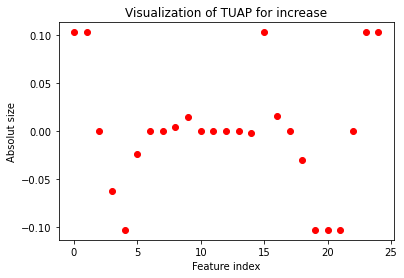

In [ ]:
#visualisation for TUAP
plt.plot([UAPs[0][i+5,3] for i in range(25)],'ro')
plt.xlabel('Feature index')
plt.ylabel('Absolut size')
plt.title('Visualization of TUAP for increase')
plt.show

<function matplotlib.pyplot.show>

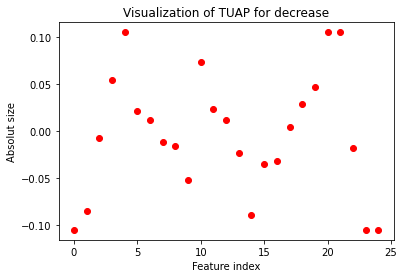

In [ ]:
plt.plot([UAPs[1][i+5,3] for i in range(25)],'ro')
plt.xlabel('Feature index')
plt.ylabel('Absolut size')
plt.title('Visualization of TUAP for decrease')
plt.show

In [ ]:
# creating graphs based on our results:
dnn_tfr = np.array([[99.3,97.9,97.3,96.1,79.7,88.4],[58.31,50.17,55.90,52.58,48.32,54.82],[51.5,52,53,49.9,48.4,56.4]])
cnn_tfr = np.array([[99.4,97.3,96.6,96.8,78.4,85.6],[60.06,52.95,53.41,50.91,46.83,55.91],[54.60,47.7,53.7,50,48.9,55.5]])
rnn_tfr = np.array([[99.1,97.6,96.8,96.4,80.7,89],[51.79,53.61,52.64,52.99,49.48,53.89],[52,45.8,51.3,48.2,49.7,57.3]])
WB_models_eval_tfr = np.array([dnn_tfr,cnn_tfr,rnn_tfr],dtype=np.float32)

dnn_ufr = np.array([[45,45.9,44.3,46.19,31.29,31.99],[22.05,22.96,15.11,13.83,6.63,6.8]])
cnn_ufr = np.array([[44.79,49.59,42.89,46.89,29.9,30.29],[22.78,25.04,17.84,15.84,10.61,8.96]])
rnn_ufr = np.array([[47.09,51.8,45.49,48.49,31.19,31.7],[26.12,24.89,15.88,16.49,7.98,10.17]])
WB_models_eval_ufr = np.array([dnn_ufr,cnn_ufr,rnn_ufr],dtype=np.float32)

comparing our results to random perturbation and the original data

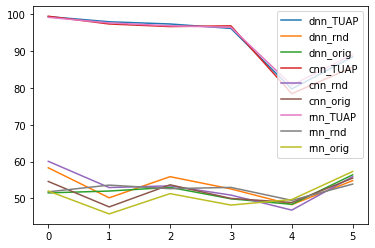

In [ ]:
for model_res in WB_models_eval_tfr:
    for row in model_res:
        plt.plot(row)
plt.legend(['dnn_TUAP','dnn_rnd','dnn_orig','cnn_TUAP','cnn_rnd','cnn_orig','rnn_TUAP','rnn_rnd','rnn_orig'])

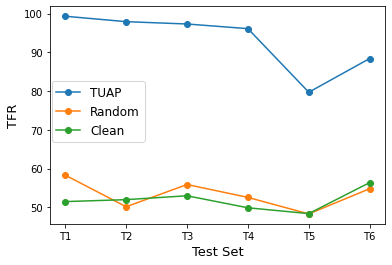

In [ ]:
# ploting each fig
test_num = ['T1','T2','T3','T4','T5','T6']

plt.plot(test_num, WB_models_eval_tfr[0,0,:], '-o')
plt.plot(test_num, WB_models_eval_tfr[0,1,:], '-o')
plt.plot(test_num, WB_models_eval_tfr[0,2,:], '-o')

plt.legend(['TUAP','Random','Clean'], fontsize=12, bbox_to_anchor=(0.3,0.35), loc="lower right")
plt.xlabel('Test Set',fontsize=13)
plt.ylabel('TFR',fontsize=13)


plt.savefig('tfr-dnn',bbox_inches='tight')

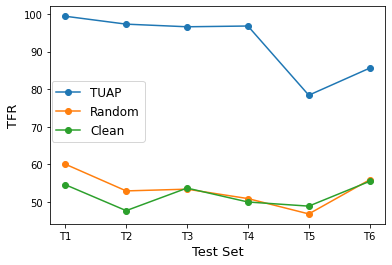

In [ ]:
# ploting each fig
plt.plot(test_num, WB_models_eval_tfr[1,0,:], '-o')
plt.plot(test_num, WB_models_eval_tfr[1,1,:], '-o')
plt.plot(test_num, WB_models_eval_tfr[1,2,:], '-o')

plt.legend(['TUAP','Random','Clean'], fontsize=12, bbox_to_anchor=(0.3,0.35), loc="lower right")
plt.xlabel('Test Set',fontsize=13)
plt.ylabel('TFR',fontsize=13)


plt.savefig('tfr-cnn',bbox_inches='tight')

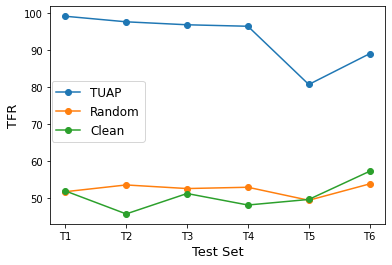

In [ ]:
# ploting each fig
plt.plot(test_num, WB_models_eval_tfr[2,0,:], '-o')
plt.plot(test_num, WB_models_eval_tfr[2,1,:], '-o')
plt.plot(test_num, WB_models_eval_tfr[2,2,:], '-o')

plt.legend(['TUAP','Random','Clean'], fontsize=12, bbox_to_anchor=(0.3,0.35), loc="lower right")
plt.xlabel('Test Set',fontsize=13)
plt.ylabel('TFR',fontsize=13)


plt.savefig('tfr-rnn',bbox_inches='tight')

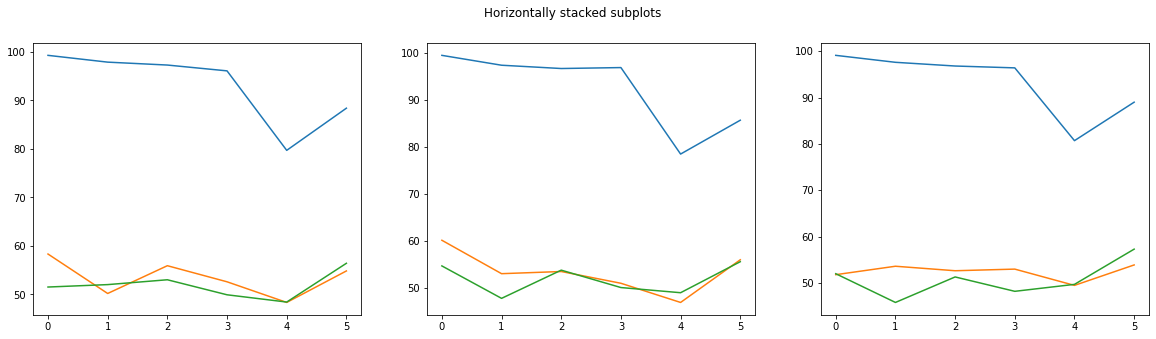

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))
fig.suptitle('Horizontally stacked subplots')

ax1.plot(WB_models_eval_tfr[0,0,:])
ax1.plot(WB_models_eval_tfr[0,1,:])
ax1.plot(WB_models_eval_tfr[0,2,:])

ax2.plot(WB_models_eval_tfr[1,0,:])
ax2.plot(WB_models_eval_tfr[1,1,:])
ax2.plot(WB_models_eval_tfr[1,2,:])

ax3.plot(WB_models_eval_tfr[2,0,:])
ax3.plot(WB_models_eval_tfr[2,1,:])
ax3.plot(WB_models_eval_tfr[2,2,:])


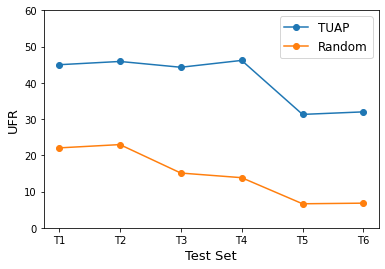

In [ ]:
# ploting each fig
plt.plot(test_num, WB_models_eval_ufr[0,0,:], '-o')
plt.plot(test_num, WB_models_eval_ufr[0,1,:], '-o')
# plt.grid()
plt.legend(['TUAP','Random','Orign'], fontsize=12)
plt.xlabel('Test Set',fontsize=13)
plt.ylabel('UFR',fontsize=13)
plt.ylim([0,60])

plt.savefig('ufr-dnn',bbox_inches='tight')

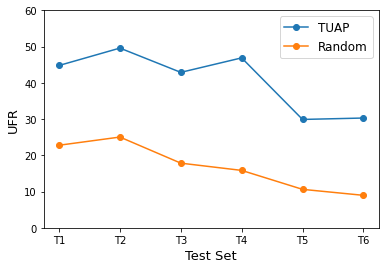

In [ ]:
# ploting each fig
plt.plot(test_num, WB_models_eval_ufr[1,0,:], '-o')
plt.plot(test_num, WB_models_eval_ufr[1,1,:], '-o')

plt.legend(['TUAP','Random','Orign'], fontsize=12)
plt.xlabel('Test Set',fontsize=13)
plt.ylabel('UFR',fontsize=13)
plt.ylim([0,60])

plt.savefig('ufr-cnn',bbox_inches='tight')

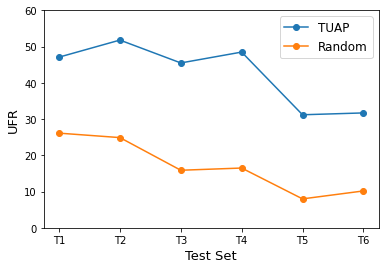

In [ ]:
# ploting each fig
plt.plot(test_num, WB_models_eval_ufr[2,0,:], '-o')
plt.plot(test_num, WB_models_eval_ufr[2,1,:], '-o')

plt.legend(['TUAP','Random','Orign'], fontsize=12)
plt.xlabel('Test Set',fontsize=13)
plt.ylabel('UFR',fontsize=13)
plt.ylim([0,60])

plt.savefig('ufr-rnn',bbox_inches='tight')

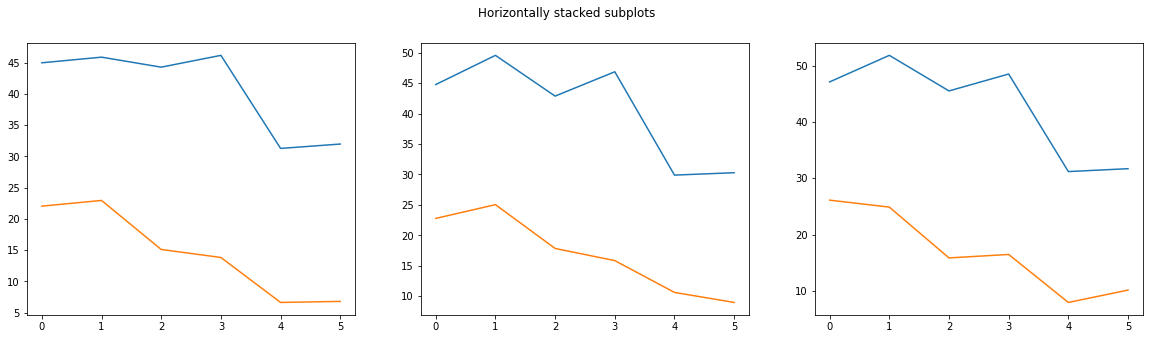

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))
fig.suptitle('Horizontally stacked subplots')

ax1.plot(WB_models_eval_ufr[0,0,:])
ax1.plot(WB_models_eval_ufr[0,1,:])

ax2.plot(WB_models_eval_ufr[1,0,:])
ax2.plot(WB_models_eval_ufr[1,1,:])

ax3.plot(WB_models_eval_ufr[2,0,:])
ax3.plot(WB_models_eval_ufr[2,1,:])


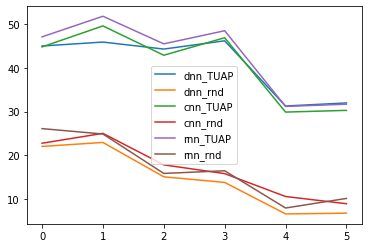

In [ ]:
for model_res in WB_models_eval_ufr:
    for row in model_res:
        plt.plot(row)
plt.legend(['dnn_TUAP','dnn_rnd','cnn_TUAP','cnn_rnd','rnn_TUAP','rnn_rnd'])

transferability results on IBM and AAPL symbols

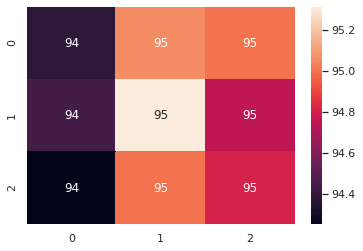

In [ ]:
import seaborn as sns; sns.set_theme()
# results from our experiments
trans_data_IBM = np.array([[94.37,95.04,95],[94.45,95.33,94.75],[94.25,95,94.83]], dtype=np.float16)
trans_data_AAPL = np.array([[93.87,93.7,93.66],[93.16,93.91,93.45],[93.95,94.62,93.95]])

ax = sns.heatmap(trans_data_IBM, annot=True)


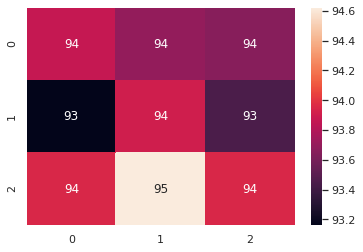

In [ ]:

ax = sns.heatmap(trans_data_AAPL, annot=True)

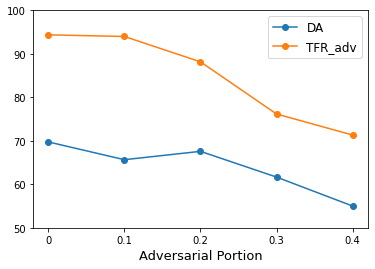

In [ ]:
# visualization for adv retraining:
adv_retraining = [[69.75,65.66,67.58,61.66,55],[94.37,93.995,88.165,76.165,71.33]]
adv_portion = ['0','0.1','0.2','0.3','0.4']
plt.plot(adv_portion, adv_retraining[0], '-o')
plt.plot(adv_portion, adv_retraining[1], '-o')

plt.legend(['DA','TFR_adv'], fontsize=12)
plt.xlabel('Adversarial Portion',fontsize=13)
# plt.ylabel('',fontsize=13)
plt.ylim([50,100])

plt.savefig('adv_retrain',bbox_inches='tight')

# Mitigation

___

Implementation and evaluation of two mitigation solutions:
- adversarial retraining
- detection of adversarial examples

In [ ]:
from sklearn.utils import shuffle

#helper functions for our mitigation solutions

# preper data with portion of adv samples
def getSamples_unlimited(X, nSamples_per_day):
    days_samples = []
    days_data = splitByDays(X[:np.int(X.shape[0]*0.7),:])
    for day in days_data:
        day_samples = sampleUniform(day,nSamples_per_day)
        days_samples.append(day_samples)
    return np.array(days_samples)

def get_adv_samples(days_samples, UAP, aggParam, lookBack):
    UAP = fitUAP(UAP, days_samples[0])
    X_adv, y_real = prep(days_samples, UAP,aggParam, lookBack)
    return X_adv, y_real

def get_portion(x,y,amount):
    indexs = np.random.random_integers(0,x.shape[0]-1,amount)
    return x.take(indexs, axis=0), y.take(indexs, axis=0)

def get_mixed_adv_by_portion(clean_x,clean_y, adv_x_up, adv_y_up, adv_x_down, adv_y_down, adv_portion = 0):
    if adv_portion == 0:
        return clean_x,clean_y
    data_len = clean_x.shape[0]
    clean_amount = int(data_len * (1 - adv_portion))
    adv_amount = (data_len - clean_amount)//2
    clean_x_part, clean_y_part = get_portion(clean_x,clean_y, clean_amount)
    adv_x_part_up, adv_y_part_up = get_portion(adv_x_up, adv_y_up, adv_amount)
    adv_x_part_down, adv_y_part_down = get_portion(adv_x_down, adv_y_down, adv_amount)
    x_mixed = np.concatenate([clean_x_part, adv_x_part_up,adv_x_part_down])
    y_mixed = np.concatenate([clean_y_part, adv_y_part_up,adv_y_part_down])
    x_mixed,y_mixed = shuffle(x_mixed, y_mixed)
    return x_mixed, y_mixed

def getSamples_test(X, nSamples_per_day):
    days_data = splitByDays(X[np.int(X.shape[0]*0.7):,:])
    test_UAP = []
    for i in range(6):
        test_UAP.append(np.concatenate([sampleUniform(days_data[i*5+3+j],nSamples_per_day) for j in range(5)],axis=0))
    return test_UAP


In [ ]:
# adv retraining pipeline
# view for white-box scenario

stocks2run = ['AAPL'] # list of symbols to be tested 
aggParam = 5
lookBack = 5
nEpochs = 12
sizes = []
results = []
for idx, Symbol in enumerate(stocks2run):
  print('Symbol: '+Symbol)
  sizes = []
  models = []
  evals = []
  #preprocess 
  X = readSymbolData(Symbol)
  X = parseTime(X)
  X = np.array(X)
  # preper the data for training:
  X_train, y_train = get_train_data(X, aggParam, lookBack)
  #save the session for later attack
  sess = tf.Session()
  keras.backend.set_session(sess)
  lockSeed()
  #build and train the model
  nFeatures = (lookBack * 3) + 2
  #creating the 3 models to attack then transfer 
  DNN_model, history = create_DNN_clf(X_train, y_train, nFeatures, nEpochs)
  train_acc = history.history['accuracy'][-1]
  val_acc = history.history['val_accuracy'][-1]

  print("train done")
 
  # create UAP for each model
  UAPs = []
  cData, test_UAP = getSamplesByDays(X, 'up')
  target_label_down = getTarget('down')
  target_label_up = getTarget('up')
  for target in [target_label_down, target_label_up]:
    UAPs.append(targeted_batch_UAP(cData, DNN_model,target, isSeries = 0))

  sizes.append([relativeSize(cData,uap) for uap in UAPs])
  base_mean_price = np.mean(cData[:,5:30,3],dtype=np.float32)
  max_size = np.max(sizes[0])/100
  print('perturb done')
  # evaluate UAPs
  tData = np.concatenate(test_UAP[:],axis=0)
  scaling = np.mean(tData[:,5:30,3],dtype=np.float32)/base_mean_price
  eval0 = []

  # _, _, model0_acc = eval_UAP(DNN_model, UAPs[0], tData, nFeatures)
  evals.append([train_acc, val_acc])

  for i in np.arange(6):
    _, _, TFR_down = eval_UAP_targeted(DNN_model, UAPs[0]*scaling, test_UAP[i], target_label_down, aggParam, lookBack, nFeatures)
    _, _, TFR_up = eval_UAP_targeted(DNN_model, UAPs[1]*scaling, test_UAP[i], target_label_up, aggParam, lookBack, nFeatures)  
    eval0.append((TFR_down+TFR_up)/2.)


Symbol: AAPL
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

train done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
perturb done



In [ ]:
# phase 2 - train robust model with adv learning
# prep adv data
days_samples = getSamples_unlimited(X, 60)
days_samples = days_samples.reshape((days_samples.shape[0]*days_samples.shape[1],days_samples.shape[2],days_samples.shape[3]))
adv_samples_up, y_real_up = get_adv_samples(days_samples, UAPs[0], 5,5)
adv_samples_down, y_real_down = get_adv_samples(days_samples, UAPs[1], 5,5)

for portion in [0.1,0.2,0.3,0.4]:
    mixed_adv_train_x, mixed_adv_train_y  = get_mixed_adv_by_portion(X_train,y_train,
                                                                 adv_samples_up, y_real_up,
                                                                 adv_samples_down, y_real_down,
                                                                 adv_portion=portion)
    # build new model
    DNN_model, history = create_DNN_clf(mixed_adv_train_x, mixed_adv_train_y, nFeatures, nEpochs)
    # eval model
    _, _, model_adv = eval_UAP(DNN_model, UAPs[0], tData, nFeatures)
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    evals.append([train_acc,val_acc])
    for i in np.arange(6):
        _, _, TFR_down = eval_UAP_targeted(DNN_model, UAPs[0]*scaling, test_UAP[i], target_label_down, aggParam, lookBack, nFeatures)
        _, _, TFR_up = eval_UAP_targeted(DNN_model, UAPs[1]*scaling, test_UAP[i], target_label_up, aggParam, lookBack, nFeatures)  
        eval0.append((TFR_down+TFR_up)/2.)
    print('done {}'.format(portion))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


done 0.1
done 0.2
done 0.3
done 0.4


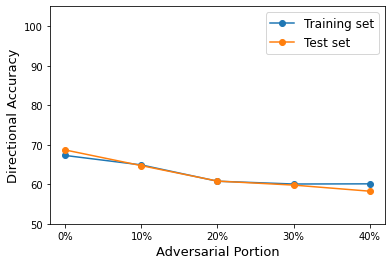

In [ ]:
# plot retrain DA
ev_train = [evals[i][0]*100 for i in np.arange(0,5)]
ev_test = [evals[i][1]*100 for i in np.arange(0,5)]
portions = ['0%','10%','20%', '30%','40%']

plt.plot(portions, ev_train, '-o')
plt.plot(portions, ev_test, '-o')

plt.legend(['Training set','Test set'], fontsize=12, )
plt.xlabel('Adversarial Portion',fontsize=13)
plt.ylabel('Directional Accuracy',fontsize=13)
plt.ylim([50,105])


plt.savefig('adv_train-da',bbox_inches='tight')

In [ ]:
ev1 = [eval0[i*6]*100 for i in np.arange(5)]
ev2 = [eval0[1+i*6]*100 for i in np.arange(5)]
ev3 = [eval0[2+i*6]*100 for i in np.arange(5)]
ev4 = [eval0[3+i*6]*100 for i in np.arange(5)]
ev5 = [eval0[4+i*6]*100 for i in np.arange(5)]
ev6 = [eval0[5+i*6]*100 for i in np.arange(5)]

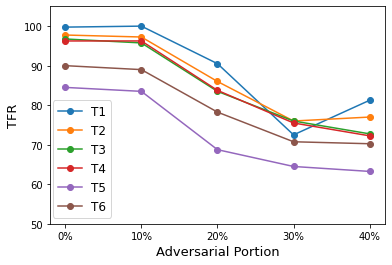

In [ ]:


portions = ['0%','10%','20%', '30%','40%']

plt.plot(portions, ev1, '-o')
plt.plot(portions, ev2, '-o')
plt.plot(portions, ev3, '-o')
plt.plot(portions, ev4, '-o')
plt.plot(portions, ev5, '-o')
plt.plot(portions, ev6, '-o')

plt.legend(['T1','T2','T3','T4','T5','T6'], fontsize=12, bbox_to_anchor=(0.2,0.0), loc="lower right")
plt.xlabel('Adversarial Portion',fontsize=13)
plt.ylabel('TFR',fontsize=13)
plt.ylim([50,105])


plt.savefig('adv_train-tfr',bbox_inches='tight')


In [ ]:
# detection of adv samples with an external detector 
# first we will try to cach anomalies after the preprocess

stocks2run = ['AAPL'] # list of symbols to be tested 
aggParam = 5
lookBack = 5
nEpochs = 12
sizes = []
results = []
for idx, Symbol in enumerate(stocks2run):
    print('Symbol: '+Symbol)
    sizes = []
    models = []
    evals = []
    #preprocess 
    X = readSymbolData(Symbol)
    X = parseTime(X)
    X = np.array(X)
    # preper the data for training:
    X_train, y_train = get_train_data(X, aggParam, lookBack)
    #save the session for later attack
    sess = tf.Session()
    keras.backend.set_session(sess)
    lockSeed()
    #build and train the model
    nFeatures = (lookBack * 3) + 2
    #creating the 3 models to attack then transfer 
    DNN_model, history = create_DNN_clf(X_train, y_train, nFeatures, nEpochs)
    models.append(DNN_model)

    print("train done")

    # create UAP for each model
    UAPs = []
    cData, test_UAP = getSamplesByDays(X, 'up')
    target_label_down = getTarget('down')
    target_label_up = getTarget('up')
    for target in [target_label_down, target_label_up]:
        UAPs.append(targeted_batch_UAP(cData, models[0],target, isSeries = 0))


Symbol: AAPL
train done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
def get_anomalous_data(x_ben, x_adv_up, x_adv_down, portion, total_nSamples):
    clean_amount = int(total_nSamples * (1 - portion))
    adv_amount = (total_nSamples - clean_amount)//2
    y_ben = np.zeros((x_ben.shape[0]))
    y_adv = np.ones((x_adv_up.shape[0]))
    x_ben_part, y_ben_part = get_portion(x_ben,y_ben, clean_amount)
    adv_x_part_up, adv_y_part_up = get_portion(x_adv_up, y_adv, adv_amount)
    adv_x_part_down, adv_y_part_down = get_portion(x_adv_down, y_adv, adv_amount)
    return np.concatenate([x_ben_part, adv_x_part_up,adv_x_part_down]), np.concatenate([y_ben_part, adv_y_part_up,adv_y_part_down])


In [ ]:
total_nSamples = 20000
portion =  0.1

# prep train data
days_samples = getSamples_unlimited(X, 60)
days_samples = days_samples.reshape((days_samples.shape[0]*days_samples.shape[1],days_samples.shape[2],days_samples.shape[3]))
adv_samples_up, y_real_up = get_adv_samples(days_samples, UAPs[0], 5,5)
adv_samples_down, y_real_down = get_adv_samples(days_samples, UAPs[1], 5,5)

x_anomalous, y_anomalous = get_anomalous_data(X_train, adv_samples_up,
                                              adv_samples_down, portion, total_nSamples)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# prep test data 
test_anomalous = []
ben_test = getSamples_test(X, 720) # to get 0.1 precent of adv 
for i in np.arange(6):
    adv_samples_up, _ = get_adv_samples(test_UAP[i], UAPs[0], 5,5)
    adv_samples_down, _ = get_adv_samples(test_UAP[i], UAPs[1], 5,5)
    ben_samples,_ = get_adv_samples(ben_test[i], UAPs[0]*0, 5,5)
    x_anomalous_test = np.concatenate([adv_samples_up,adv_samples_down,ben_samples],axis=0)
    y_anomalous_test = np.zeros((x_anomalous_test.shape[0]))
    y_anomalous_test[0:adv_samples_down.shape[0]*2] = 1
    test_anomalous.append([x_anomalous_test,y_anomalous_test])




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_anomalous[:,:nFeatures], y_anomalous)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# test the detector for anomalous data t1-t6:
results = []

for i in np.arange(6):
    preds = knn.predict(test_anomalous[i][0][:,:17])
    cm = confusion_matrix(test_anomalous[i][1],preds)
    results.append(cm)

In [ ]:
# test the detector for anomalous data t1-t6:

for i in np.arange(6):
    preds = clf.predict(test_anomalous[i][0][:,:17])
    cm = confusion_matrix(test_anomalous[i][1],preds)
    results.append(cm)

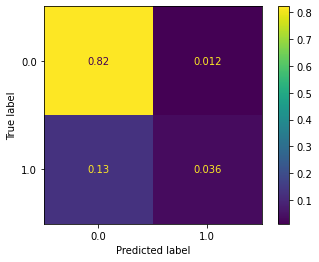

In [ ]:
from sklearn.metrics import  plot_confusion_matrix

plot_confusion_matrix(knn, test_anomalous[i][0][:,:17], test_anomalous[i][1], normalize='all')  

i+=1

In [ ]:
# ann

model = Sequential()

model.add(Dense(30, activation='relu', input_shape=(nFeatures,)))

# model.add(Dense(25, activation='relu'))
model.add(Dense(10, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_anomalous[:,:nFeatures], keras.utils.to_categorical(y_anomalous, num_classes=2, dtype='float32')
 ,epochs=nEpochs,shuffle=True,verbose=1)

Epoch 1/12
20000/20000 [==============================] - 1s 68us/step - loss: 0.4131 - accuracy: 0.8671
Epoch 2/12
20000/20000 [==============================] - 1s 56us/step - loss: 0.3245 - accuracy: 0.9000
Epoch 3/12
20000/20000 [==============================] - 1s 54us/step - loss: 0.2707 - accuracy: 0.8977
Epoch 4/12
20000/20000 [==============================] - 1s 53us/step - loss: 0.2057 - accuracy: 0.9068
Epoch 5/12
20000/20000 [==============================] - 1s 55us/step - loss: 0.1751 - accuracy: 0.9233
Epoch 6/12
20000/20000 [==============================] - 1s 53us/step - loss: 0.1581 - accuracy: 0.9326
Epoch 7/12
20000/20000 [==============================] - 1s 52us/step - loss: 0.1544 - accuracy: 0.9341
Epoch 8/12
20000/20000 [==============================] - 1s 53us/step - loss: 0.1502 - accuracy: 0.9360
Epoch 9/12
20000/20000 [==============================] - 1s 53us/step - loss: 0.1454 - accuracy: 0.9396
Epoch 10/12
20000/20000 [==============================

In [ ]:
for i in np.arange(6):
    preds = model.predict(test_anomalous[i][0][:,:17])
    cm = confusion_matrix(test_anomalous[i][1],np.argmax(preds, axis=1))
    results.append(cm)

In [ ]:
preds = model.predict(test_anomalous[0][0][:,:nFeatures])

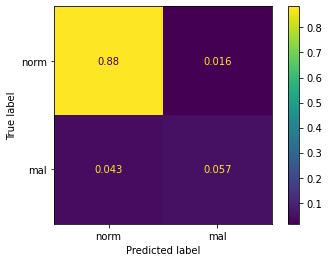

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_anomalous,np.argmax(preds, axis=1), normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['norm','mal'])
disp.plot()

In [ ]:
days_data = splitByDays(X[np.int(X.shape[0]*0.7):,:])

a = np.concatenate([sampleUniform(days_data[3+j],40) for j in range(5)],axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# test the detector for anomalous data t1-t6:
results = []
mal_labels = np.ones((test_anomalous[0][0].shape[0]))
for test in test_anomalous:
    preds = model.predict(test[0][:,:17])
    cm_up = confusion_matrix(mal_labels,np.argmax(preds, axis=1))
    preds = model.predict(test[1][:,:17])
    cm_down = confusion_matrix(mal_labels,np.argmax(preds, axis=1))
    results.append([cm_up,cm_down])

In [ ]:
# prep test data 
test_norm = []
for test in test_UAP:
    adv_samples_up, _ = get_adv_samples(test, UAPs[0]*0, 5,5)
    test_norm.append([adv_samples_up])

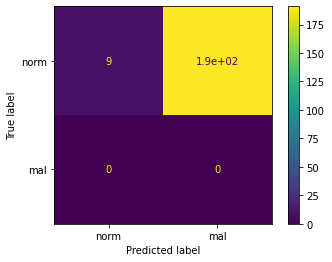

In [ ]:

disp = ConfusionMatrixDisplay(confusion_matrix=results[0][0], display_labels=['norm','mal'])
disp.plot()

In [ ]:
def calc_percision_recall(cm):
    tn, fp = cm[0]
    fn, tp = cm[1] 
    recall = tp/(tp+fn)
    percision = tp/(tp+fp)
    return percision, recall

In [ ]:
res = []
for cm in results:
    res.append(calc_percision_recall(cm))

KNN detection results

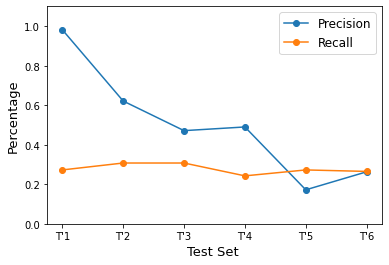

In [ ]:

test_num = ["T'1","T'2","T'3","T'4","T'5","T'6"]
per_knn = [res[i][0] for i in np.arange(0,6)]
rec_knn = [res[i][1] for i in np.arange(0,6)]

plt.plot(test_num, per_knn, '-o')
plt.plot(test_num, rec_knn, '-o')

plt.legend(['Precision','Recall'], fontsize=12)
plt.xlabel('Test Set ',fontsize=13)
plt.ylabel('Percentage',fontsize=13)
plt.ylim([0,1.1])


plt.savefig('knn-detection',bbox_inches='tight')

ANN detection results

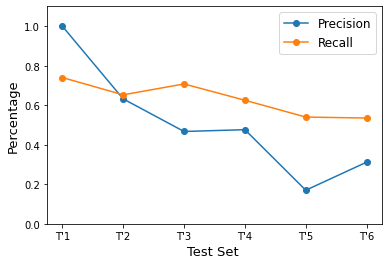

In [ ]:
test_num = ["T'1","T'2","T'3","T'4","T'5","T'6"]
per_knn = [res[i][0] for i in np.arange(12,18)]
rec_knn = [res[i][1] for i in np.arange(12,18)]

plt.plot(test_num, per_knn, '-o')
plt.plot(test_num, rec_knn, '-o')

plt.legend(['Precision','Recall'], fontsize=12)
plt.xlabel('Test Set ',fontsize=13)
plt.ylabel('Percentage',fontsize=13)
plt.ylim([0,1.1])


plt.savefig('ann-detection',bbox_inches='tight')